# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
# Import necessary libraries
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
import importlib.util as ilu
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0])
# in standard python
#module_path = str(Path.cwd(__file__).parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import read_data as rd


d:\Miniconda3\envs\welokaTorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Model Choice

[Explain why you've chosen a particular model as the baseline. This could be a simple statistical model or a basic machine learning model. Justify your choice.]


## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]


In [2]:
# Load the dataset
weather_df, sales_df, product_group_dict = rd.read_data()
weather_df = weather_df.dropna() # drop rows with missing values
merged_df = pd.merge(weather_df, sales_df, on='Date', how='inner') # inner join uses only date that are present in both dataframes

merged_df['Day_of_week'] = merged_df['Date'].dt.weekday # add day of week column   
merged_df['Month'] = merged_df['Date'].dt.month # add month column
merged_df['Day'] = merged_df['Date'].dt.day # add day column

merged_df = merged_df.astype({'Day_of_week': 'category', 'Month': 'category'})

print(merged_df.dtypes)

# Feature selection
# delete nnav and wwav columns (negative correlation with sales)
#merged_df.drop(['nnav', 'wwav'], axis=1, inplace=True) 

merged_df.set_index('Date', inplace=True)
merged_df.head()


Date             datetime64[ns]
nnav                   category
ttav                    float64
ffav                      int64
wwav                    float64
Filiale                category
Product Group          category
Sales                   float64
Day_of_week            category
Month                  category
Day                       int32
dtype: object


,nnav,ttav,ffav,wwav,Filiale,Product Group,Sales,Day_of_week,Month,Day
Date,,,,,,,,,,
2015-01-02,6.0,7.75,24,61.0,2,12,36.972801,4,1,2
2015-01-02,6.0,7.75,24,61.0,3,2,60.101109,4,1,2
2015-01-02,6.0,7.75,24,61.0,1,11,266.254971,4,1,2
2015-01-02,6.0,7.75,24,61.0,3,9,89.217757,4,1,2
2015-01-02,6.0,7.75,24,61.0,2,4,58.999279,4,1,2


In [3]:
print(merged_df['Day_of_week'].unique())
print(merged_df['Month'].unique())

[4, 5, 0, 1, 2, 3, 6]
Categories (7, int32): [0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, ..., 8, 9, 10, 11, 12]
Length: 12
Categories (12, int32): [1, 2, 3, 4, ..., 9, 10, 11, 12]


In [4]:
# change categorical columns to one-hot encoding
merged_df = pd.get_dummies(merged_df)
print('features shape: ', len(merged_df), len(merged_df.columns))
merged_df.dtypes
      #merged_df.describe(include='all').transpose()

features shape:  46230 49


ttav                float64
ffav                  int64
wwav                float64
Sales               float64
Day                   int32
nnav_0.0               bool
nnav_1.0               bool
nnav_2.0               bool
nnav_3.0               bool
nnav_4.0               bool
nnav_5.0               bool
nnav_6.0               bool
nnav_7.0               bool
nnav_8.0               bool
Filiale_1              bool
Filiale_2              bool
Filiale_3              bool
Product Group_1        bool
Product Group_2        bool
Product Group_3        bool
Product Group_4        bool
Product Group_5        bool
Product Group_6        bool
Product Group_7        bool
Product Group_8        bool
Product Group_9        bool
Product Group_10       bool
Product Group_11       bool
Product Group_12       bool
Product Group_13       bool
Day_of_week_0          bool
Day_of_week_1          bool
Day_of_week_2          bool
Day_of_week_3          bool
Day_of_week_4          bool
Day_of_week_5       

In [5]:
# scale the data
#data_scaler = MinMaxScaler()
dataset_df = merged_df.astype('float64')
labels_df = dataset_df.pop('Sales')

dataset_npy = dataset_df.to_numpy()
labels_npy = labels_df.to_numpy()


In [6]:
# form training and test sets

# split into train and test sets
X_train, X_val, y_train, y_val = train_test_split(dataset_npy, labels_npy, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42) 

(len(X_train), len(y_train)), (len(X_val), len(y_val)) , (len(X_test), len(y_test))

((29124, 29124), (13869, 13869), (3237, 3237))

## Implementation

[Implement your baseline model here.]



In [7]:
# Initialize and train the baseline model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1)
])

model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = tf.keras.optimizers.RMSprop())

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=32,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]
                    )


Epoch 1/200
911/911 [==============================] - 2s 2ms/step - loss: 13890.2471 - val_loss: 10076.9902
Epoch 2/200
911/911 [==============================] - 2s 2ms/step - loss: 8265.8271 - val_loss: 6407.7324
Epoch 3/200
911/911 [==============================] - 2s 2ms/step - loss: 6672.5908 - val_loss: 5753.2368
Epoch 4/200
911/911 [==============================] - 2s 2ms/step - loss: 6041.8491 - val_loss: 5115.7905
Epoch 5/200
911/911 [==============================] - 2s 2ms/step - loss: 5447.2705 - val_loss: 4583.3530
Epoch 6/200
911/911 [==============================] - 2s 2ms/step - loss: 4998.7603 - val_loss: 4311.2632
Epoch 7/200
911/911 [==============================] - 2s 2ms/step - loss: 4621.1782 - val_loss: 3962.5374
Epoch 8/200
911/911 [==============================] - 2s 2ms/step - loss: 4296.9775 - val_loss: 3603.5117
Epoch 9/200
911/911 [==============================] - 2s 2ms/step - loss: 3971.9324 - val_loss: 3205.3872
Epoch 10/200
911/911 [=============

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



  1/102 [..............................] - ETA: 2s

102/102 [==============================] - 0s 931us/step


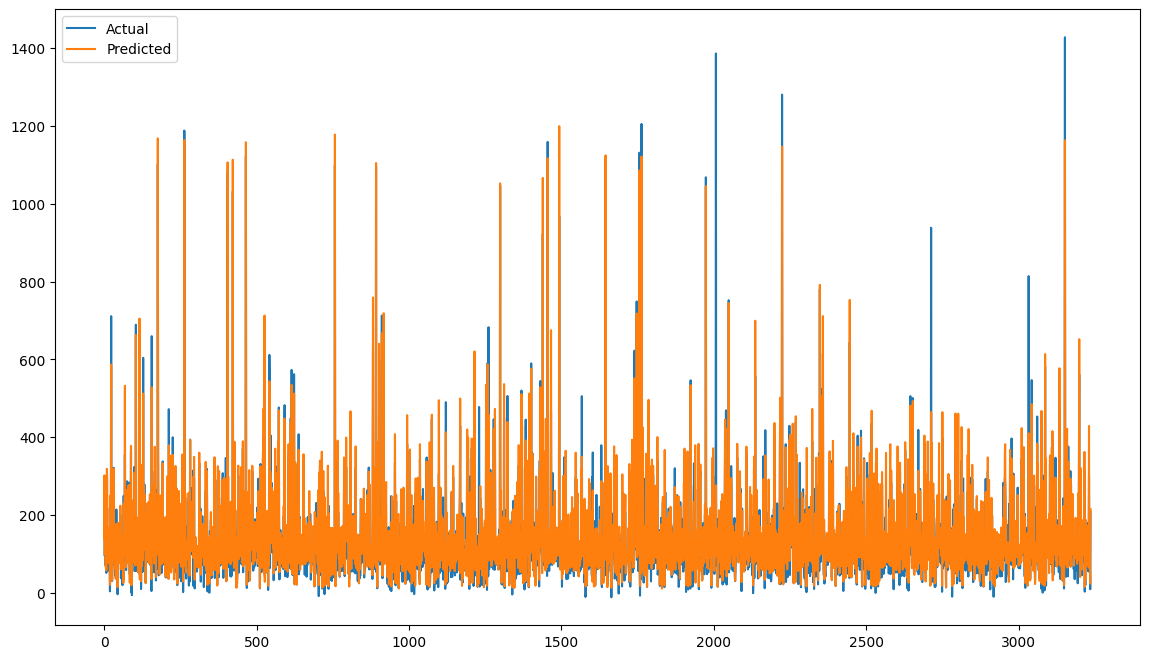

In [10]:
# Evaluate the baseline model
y_pred = model.predict(X_test)
#y_pred = Y_scaler.inverse_transform(y_pred_scaled)

#y_test = Y_scaler.inverse_transform(y_test)

#print(y_pred.shape, y_test.shape)
x = np.arange(len(y_test))

# plot the results
plt.figure(figsize=(14,8))
plt.plot(x, y_test, label='Actual')
plt.plot(x, y_pred, label='Predicted')
plt.legend()
plt.show()



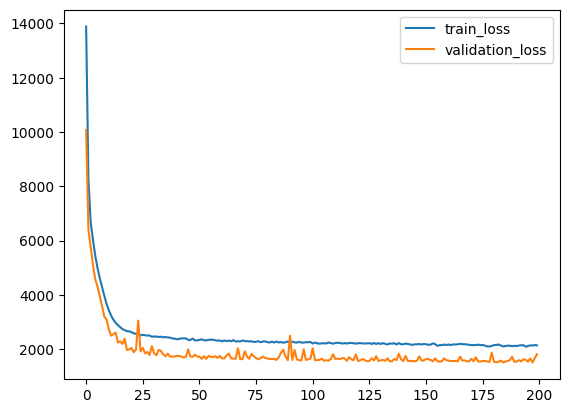

In [12]:
# plot the loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()